In [39]:
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import numpy as np
import torch_geometric.transforms as T
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('shuffled_dataset_new.csv', na_values=['NA', 'N/A', '-', ''])

In [48]:
# Step 2: Handle NaN values
# df.interpolate(method='linear', inplace=True)  # Linear interpolation


# Step 3: Extract features (X) and target labels (y)
X = torch.tensor(df.iloc[:, :-5].values, dtype=torch.float)
y = torch.tensor(df.iloc[:, -5:].values, dtype=torch.float)

In [49]:
# Step 4: Prepare the graph data
data = Data(x=X, y=y)
data = T.NormalizeFeatures()(data)
data = T.ToSparseTensor()(data)

# Define the number of features based on processed data
num_features = data.num_features

# Define the edges based on the complete graph approach
edges = []
for i in range(num_features):
    for j in range(i + 1, num_features):  # Connect nodes that are consecutive
        edges.append([i, j])

# Convert edges to a NumPy array
edges = np.array(edges).T

# Convert edges to PyTorch tensor with dtype=torch.long
edge_index = torch.tensor(edges, dtype=torch.long)

In [50]:
# Step 5: Define the GNN architecture
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)  # Adjust input dimension
        self.conv2 = GCNConv(64, 64)
        self.fc = nn.Linear(64, 5)  # Adjust output dimension to match number of classes

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training, p=0.2)  # Add dropout for regularization
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x


In [51]:
# shuffling the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Step 6: Train the GCN model
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [52]:
model = GCN()

# Define the loss function and optimizer (consider adjusting learning rate if needed)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [53]:
# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train, edge_index)
    loss = criterion(output, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")

Epoch: 10, Loss: 0.3126
Epoch: 20, Loss: 0.1281
Epoch: 30, Loss: 0.0458
Epoch: 40, Loss: 0.0119
Epoch: 50, Loss: 0.0067
Epoch: 60, Loss: 0.0057
Epoch: 70, Loss: 0.0057
Epoch: 80, Loss: 0.0048
Epoch: 90, Loss: 0.0047
Epoch: 100, Loss: 0.0045


Test Accuracy: 0.9987843137254901


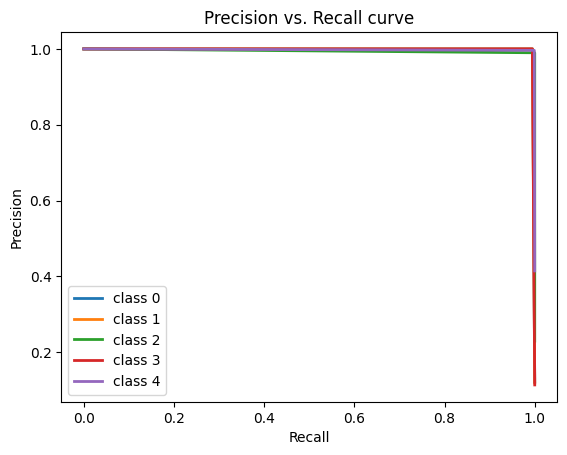

In [55]:
label_names = ["SQL Injection (SQLi)", "Cross-Site Scripting (XSS)", "Command/Code Injection", 
               "File Inclusion", "Prototype Pollution"]

model.eval()
with torch.no_grad():
    output = model(X_test, edge_index)
    pred = (torch.sigmoid(output) > 0.5).int()  # Threshold probabilities to get binary predictions
    correct = (pred == y_test).sum().item()
    total = y_test.size(0) * y_test.size(1)
    accuracy = correct / total
    print("Test Accuracy:", accuracy)

    # Calculate precision and recall
    precision = dict()
    recall = dict()
    for i in range(5):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision vs. Recall curve")
    plt.show()

    # Convert tensors to numpy arrays
y_test_np = y_test.numpy()
pred_np = pred.numpy()

# Flatten the arrays for binary classification
y_test_flat = y_test_np.flatten()
pred_flat = pred_np.flatten() # Threshold probabilities to get binary predictions

    

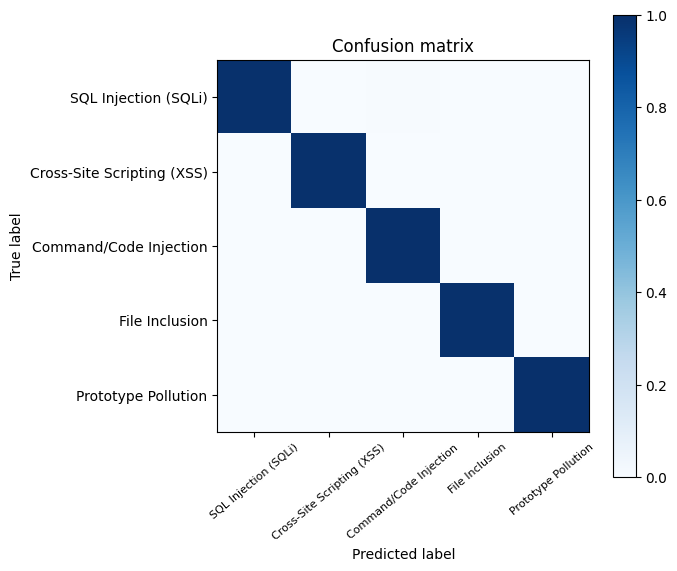

In [56]:
def plot_confusion_matrix(Y_test, Y_pred, class_labels):
    if isinstance(Y_test, pd.DataFrame):
        Y_test = Y_test.values
    if isinstance(Y_pred, pd.DataFrame):
        Y_pred = Y_pred.values

    cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    cm = cm / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, label_names, rotation=40, fontsize=8)
    plt.yticks(tick_marks, label_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, pred, label_names)

In [57]:
print(classification_report(y_test_np, pred_np))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       622
           1       1.00      1.00      1.00       609
           2       0.99      1.00      0.99      1172
           3       1.00      0.99      1.00       582
           4       1.00      1.00      1.00      2115

   micro avg       1.00      1.00      1.00      5100
   macro avg       1.00      1.00      1.00      5100
weighted avg       1.00      1.00      1.00      5100
 samples avg       1.00      1.00      1.00      5100



/home/srn/bloom-experiment-lab/dataprocessing/parsergen/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
